<a href="https://colab.research.google.com/github/minjeon99/6th-Intermediate/blob/Week11/Github_Batch_Normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Batch Normalization in PyTorch

In [1]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 64

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# get the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                            download=True, transform=transform)

test_data = datasets.MNIST(root='data', train=False,
                           download=True, transform=transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          num_workers=num_workers)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15859542.45it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 477323.73it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3796333.81it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4100415.15it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



# Visualize the data

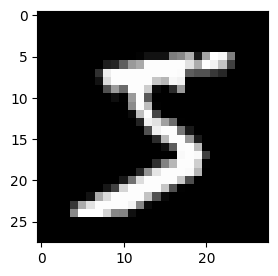

In [4]:
# obtain one batch of training images
images, labels = next(iter(train_loader))
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (3,3))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

# Neural network classes for testing

## (Important) Model Details

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class NeuralNet(nn.Module):
    def __init__(self, use_batch_norm, input_size=784, hidden_dim=256, output_size=10):
        """
        Creates a PyTorch net using the given parameters.

        :param use_batch_norm: bool
            Pass True to create a network that uses batch normalization; False otherwise
            Note: this network will not use batch normalization on layers that do not have an
            activation function.
        """
        super(NeuralNet, self).__init__() # init super

        # Default layer sizes
        self.input_size = input_size # (28*28 images)
        self.hidden_dim = hidden_dim
        self.output_size = output_size # (number of classes)
        # Keep track of whether or not this network uses batch normalization.
        self.use_batch_norm = use_batch_norm

        # define hidden linear layers, with optional batch norm on their outputs
        # layers with batch_norm applied have no bias term
        if use_batch_norm:
            self.fc1 = nn.Linear(input_size, hidden_dim*2, bias=False)
            self.batch_norm1 = nn.BatchNorm1d(hidden_dim*2)
        else:
            self.fc1 = nn.Linear(input_size, hidden_dim*2)

        # define *second* hidden linear layers, with optional batch norm on their outputs
        if use_batch_norm:
            self.fc2 = nn.Linear(hidden_dim*2, hidden_dim, bias=False)
            self.batch_norm2 = nn.BatchNorm1d(hidden_dim)
        else:
            self.fc2 = nn.Linear(hidden_dim*2, hidden_dim)

        # third and final, fully-connected layer
        self.fc3 = nn.Linear(hidden_dim, output_size)


    def forward(self, x):
        # flatten image
        x = x.view(-1, 28*28)
        # all hidden layers + optional batch norm + relu activation
        x = self.fc1(x)
        if self.use_batch_norm:
            x = self.batch_norm1(x)
        x = F.relu(x)
        # second layer
        x = self.fc2(x)
        if self.use_batch_norm:
            x = self.batch_norm2(x)
        x = F.relu(x)
        # third layer, no batch norm or activation
        x = self.fc3(x)
        return x

## Create two different models for testing

In [6]:
net_batchnorm = NeuralNet(use_batch_norm=True)
net_no_norm = NeuralNet(use_batch_norm=False)

print(net_batchnorm)
print()
print(net_no_norm)

NeuralNet(
  (fc1): Linear(in_features=784, out_features=512, bias=False)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=False)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

NeuralNet(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


# Training

In [7]:
def train(model, n_epochs=10):
    # number of epochs to train the model
    n_epochs = n_epochs
    # track losses
    losses = []

    # optimization strategy
    # specify loss function (categorical cross-entropy)
    criterion = nn.CrossEntropyLoss()

    # specify optimizer (stochastic gradient descent) and learning rate = 0.01
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

    # set the model to training mode
    model.train()

    for epoch in range(1, n_epochs+1):
        # monitor training loss
        train_loss = 0.0

        ###################
        # train the model #
        ###################
        batch_count = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update average training loss
            train_loss += loss.item() # add up avg batch loss
            batch_count +=1

        # print training statistics
        losses.append(train_loss/batch_count)
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(
            epoch,
            train_loss/batch_count))

    # return all recorded batch losses
    return losses

# Comparing Models

In [8]:
# batchnorm model losses
# this may take some time to train
losses_batchnorm = train(net_batchnorm)

Epoch: 1 	Training Loss: 0.392651
Epoch: 2 	Training Loss: 0.163561
Epoch: 3 	Training Loss: 0.113543
Epoch: 4 	Training Loss: 0.084605
Epoch: 5 	Training Loss: 0.064840
Epoch: 6 	Training Loss: 0.050395
Epoch: 7 	Training Loss: 0.039500
Epoch: 8 	Training Loss: 0.031098
Epoch: 9 	Training Loss: 0.024643
Epoch: 10 	Training Loss: 0.019686


In [9]:
# *no* norm model losses
# you should already start to see a difference in training losses
losses_no_norm = train(net_no_norm)

Epoch: 1 	Training Loss: 1.564356
Epoch: 2 	Training Loss: 0.513904
Epoch: 3 	Training Loss: 0.375964
Epoch: 4 	Training Loss: 0.328759
Epoch: 5 	Training Loss: 0.299872
Epoch: 6 	Training Loss: 0.277422
Epoch: 7 	Training Loss: 0.258264
Epoch: 8 	Training Loss: 0.241269
Epoch: 9 	Training Loss: 0.226129
Epoch: 10 	Training Loss: 0.212591


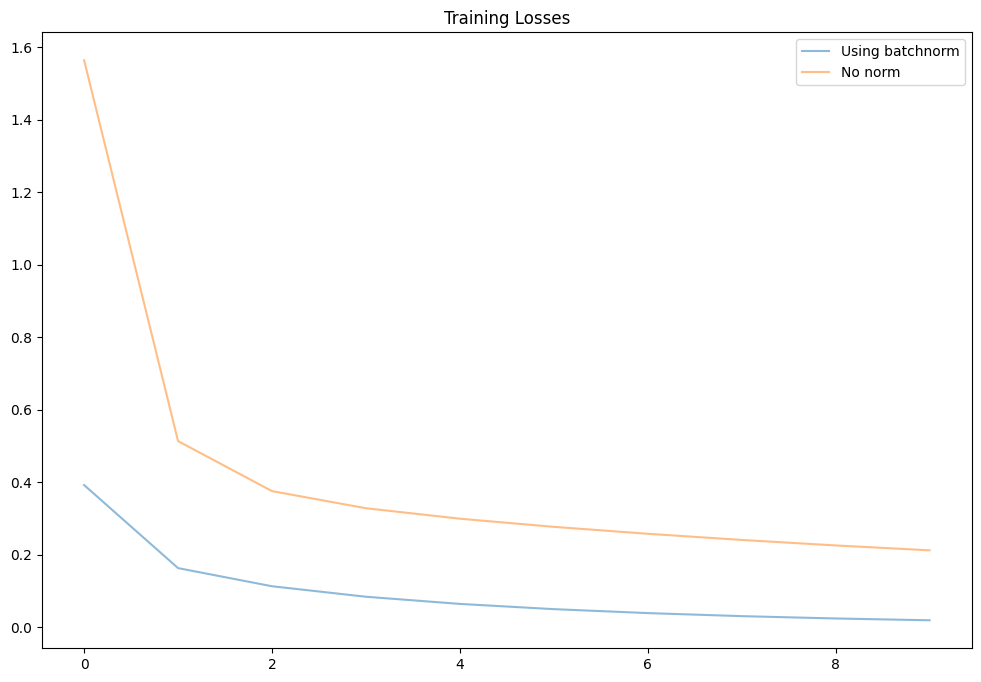

In [10]:
# compare
fig, ax = plt.subplots(figsize=(12,8))
#losses_batchnorm = np.array(losses_batchnorm)
#losses_no_norm = np.array(losses_no_norm)
plt.plot(losses_batchnorm, label='Using batchnorm', alpha=0.5)
plt.plot(losses_no_norm, label='No norm', alpha=0.5)
plt.title("Training Losses")
plt.legend()

# Testing

In [11]:
def test(model, train):
    # initialize vars to monitor test loss and accuracy
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    test_loss = 0.0

    # set model to train or evaluation mode
    # just to see the difference in behavior
    if(train==True):
        model.train()
    if(train==False):
        model.eval()

    # loss criterion
    criterion = nn.CrossEntropyLoss()

    for batch_idx, (data, target) in enumerate(test_loader):
        batch_size = data.size(0)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss
        test_loss += loss.item()*batch_size
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        # calculate test accuracy for each object class
        for i in range(batch_size):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    print('Test Loss: {:.6f}\n'.format(test_loss/len(test_loader.dataset)))

    for i in range(10):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                str(i), 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))

# Training and Evaluation Mode

In [12]:
# test batchnorm case, in *train* mode
test(net_batchnorm, train=True)

Test Loss: 0.081530

Test Accuracy of     0: 98% (969/980)
Test Accuracy of     1: 99% (1126/1135)
Test Accuracy of     2: 96% (996/1032)
Test Accuracy of     3: 97% (981/1010)
Test Accuracy of     4: 97% (957/982)
Test Accuracy of     5: 97% (869/892)
Test Accuracy of     6: 97% (935/958)
Test Accuracy of     7: 97% (998/1028)
Test Accuracy of     8: 96% (937/974)
Test Accuracy of     9: 95% (965/1009)

Test Accuracy (Overall): 97% (9733/10000)


In [13]:
# test batchnorm case, in *evaluation* mode
test(net_batchnorm, train=False)

Test Loss: 0.067706

Test Accuracy of     0: 99% (971/980)
Test Accuracy of     1: 99% (1127/1135)
Test Accuracy of     2: 97% (1007/1032)
Test Accuracy of     3: 97% (987/1010)
Test Accuracy of     4: 97% (961/982)
Test Accuracy of     5: 98% (879/892)
Test Accuracy of     6: 97% (937/958)
Test Accuracy of     7: 96% (996/1028)
Test Accuracy of     8: 96% (940/974)
Test Accuracy of     9: 97% (985/1009)

Test Accuracy (Overall): 97% (9790/10000)


In [14]:
# for posterity, test no norm case in eval mode
test(net_no_norm, train=False)

Test Loss: 0.204840

Test Accuracy of     0: 98% (966/980)
Test Accuracy of     1: 98% (1113/1135)
Test Accuracy of     2: 91% (943/1032)
Test Accuracy of     3: 93% (943/1010)
Test Accuracy of     4: 93% (916/982)
Test Accuracy of     5: 93% (833/892)
Test Accuracy of     6: 94% (909/958)
Test Accuracy of     7: 92% (956/1028)
Test Accuracy of     8: 91% (892/974)
Test Accuracy of     9: 93% (942/1009)

Test Accuracy (Overall): 94% (9413/10000)
